In [1]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io
import ast
import koreanize_matplotlib

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'  # Windows # 나눔고딕 가능
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [2]:
client = storage.Client()

bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

## 1. accounts_attendance(출석)

In [3]:
blob = bucket.blob('votes/accounts_attendance.parquet')
parquet_bytes = blob.download_as_bytes()
attendance = pd.read_parquet(io.BytesIO(parquet_bytes))
attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [9]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [7]:
# 사용 데이터 기간 6,7,8,월

# 출석 횟수를 알아보자
attendance_df = attendance.copy()

# attendance_date_list 리스트 변환
attendance_df['attendance_date_list'] = attendance_df['attendance_date_list'].apply(ast.literal_eval)

# 출석 횟수 계산
attendance_df['attendance_count'] = attendance_df['attendance_date_list'].apply(len)

print(attendance_df[['user_id', 'attendance_count']])

        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349637 rows x 2 columns]


In [ ]:
# 월별 출석 확인 회수 확인

# explode로 풀어서 하나의 row로
attendance_exploded = attendance_df.explode('attendance_date_list')
attendance_exploded['attendance_date_list'] = pd.to_datetime(attendance_exploded['attendance_date_list'])
attendance_exploded

,id,attendance_date_list,user_id,attendance_count
0,1,2023-05-27,1446852,13
0,1,2023-05-28,1446852,13
0,1,2023-05-29,1446852,13
0,1,2023-05-30,1446852,13
0,1,2023-06-03,1446852,13
...,...,...,...,...
349632,360501,NaT,897005,0
349633,360502,2024-05-09,1407059,1
349634,360503,2024-05-09,1583727,1
349635,360504,2024-05-09,1392372,1


In [33]:
attendance_exploded[attendance_exploded['user_id'] == 897005]

,id,attendance_date_list,user_id,attendance_count,month
349632,360501,NaT,897005,0,NaN


In [ ]:
attendance_exploded['']

In [ ]:

attendance_exploded['month'] = attendance_exploded['attendance_date_list'].dt.month
attendance_filtered = attendance_exploded[attendance_exploded['month'].isin([5,6,7])]

attendance_count = attendance_filtered.groupby(['user_id', 'month']).size().reset_index(name='attendance_count')
attendance_count['month'] = attendance_count['month'].astype(int)
attendance_count

,user_id,month,attendance_count
0,832151,5,1
1,832340,6,2
2,832986,5,1
3,833041,5,5
4,833041,6,9
...,...,...,...
552918,1583708,5,1
552919,1583710,5,1
552920,1583715,5,1
552921,1583727,5,1


In [26]:
attendance_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552923 entries, 0 to 552922
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   user_id           552923 non-null  int64
 1   month             552923 non-null  int64
 2   attendance_count  552923 non-null  int64
dtypes: int64(3)
memory usage: 12.7 MB


In [28]:
# 5,6,7 월별 출석휫수 시각화
monthly_attendance = attendance_count.groupby('month')['attendance_count'].sum().reset_index()
monthly_attendance.columns = ['월', '출석횟수']
monthly_attendance = monthly_attendance.sort_values('월')  # 월별 정렬
monthly_attendance

,월,출석횟수
0,5,611941
1,6,1232776
2,7,200306


In [24]:
# 피봇 테이블 형성 -> 더 보기 좋게
attendance_pivot = attendance_count.pivot(index='user_id', columns='month', values='attendance_count').fillna(0).astype(int)
attendance_pivot.columns = [f'{month}월' for month in attendance_pivot.columns]
attendance_pivot

,5월,6월,7월
user_id,,,
832151,1,0,0
832340,0,2,0
832986,1,0,0
833041,5,9,18
833154,1,0,0
...,...,...,...
1583708,1,0,0
1583710,1,0,0
1583715,1,0,0


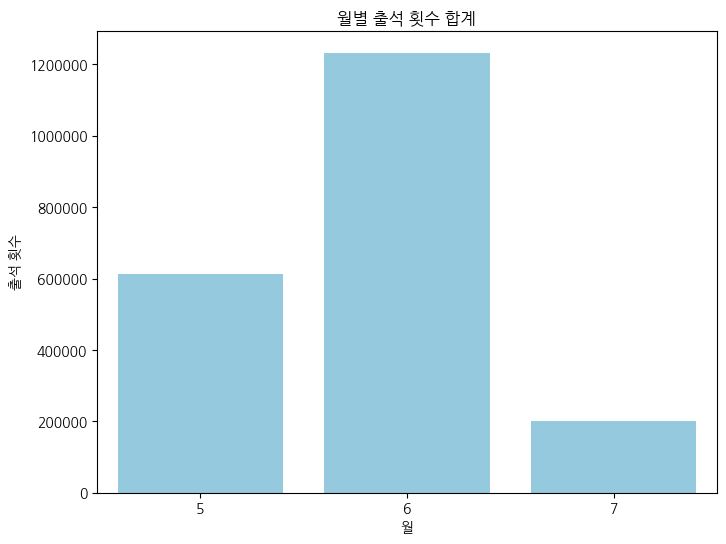

In [31]:
plt.figure(figsize=(8, 6))
sns.barplot(x='월', y='출석횟수', data=monthly_attendance, color='skyblue')
plt.xlabel('월')
plt.ylabel('출석 횟수')
plt.title('월별 출석 횟수 합계')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

attendance에서는 뽑을 하위 지표가 존재하지 않을 것으로 보임

##### 좀 더 알아보고 싶은 것
    - 출석에서 []인 경우의 유저들이 정말 활동 기록이 없는 것인가
        - 다른 votes 테이블들과 결합하여 알아보는 것 필요
        - 5월,6월 hackle에서는 click_attendance 존재하지 않음(click_attendacne는 7,8월에만 존재)
    => 그러면 빈 칸은 어떻게 판단??
    => 7월달 []과 hackle 교차 검증 필요?(추후 hackle 합의)

## 2. accounts_blockboard(차단 기록) 

In [66]:
blob = bucket.blob('votes/accounts_blockrecord.parquet')
parquet_bytes = blob.download_as_bytes()
blockrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
blockrecord.head()

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177


In [67]:
blockrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 761.1+ KB


In [68]:
# reason, block_user_id, user_id가 모두 중복이면?? 중복처리???(created_at은 고려하지 않음)
blockrecord_duplicated = blockrecord[blockrecord.duplicated(subset=['reason', 'block_user_id', 'user_id'], keep=False)]
blockrecord_duplicated

,id,reason,created_at,block_user_id,user_id
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
12,16,기타,2023-05-05 13:05:01,885794,879662
13,17,친구 사이가 어색해짐,2023-05-05 13:17:19,886605,881070
...,...,...,...,...,...
19227,24885,모르는 사람임,2023-08-15 18:38:38,992181,1072478
19228,24886,모르는 사람임,2023-08-15 18:38:41,992181,1072478
19240,24899,친구 사이가 어색해짐,2023-08-18 12:12:28,1500131,1365572
19295,25105,모르는 사람임,2023-09-11 14:09:18,1019326,976341


In [72]:
# reason, block_user_id, user_id, created_at(날짜와 시가 동일한 경우) 중복으로 봄봄

blockrecord_time = blockrecord.copy()

# 시 단위로 반올림 (분/초 제거)
blockrecord_time['created_at_hour'] = blockrecord_time['created_at'].dt.floor('H')

# 중복 체크
blockrecord_duplicated = blockrecord_time[
    blockrecord_time.duplicated(subset=['reason', 'block_user_id', 'user_id', 'created_at_hour'], keep=False)
]
blockrecord_duplicated

,id,reason,created_at,block_user_id,user_id,created_at_hour
8,12,기타,2023-05-05 13:04:31,885794,879662,2023-05-05 13:00:00
9,13,기타,2023-05-05 13:04:42,885794,879662,2023-05-05 13:00:00
11,15,기타,2023-05-05 13:04:56,885794,879662,2023-05-05 13:00:00
12,16,기타,2023-05-05 13:05:01,885794,879662,2023-05-05 13:00:00
13,17,친구 사이가 어색해짐,2023-05-05 13:17:19,886605,881070,2023-05-05 13:00:00
...,...,...,...,...,...,...
19190,24808,친구 사이가 어색해짐,2023-08-09 20:39:12,951564,1569648,2023-08-09 20:00:00
19227,24885,모르는 사람임,2023-08-15 18:38:38,992181,1072478,2023-08-15 18:00:00
19228,24886,모르는 사람임,2023-08-15 18:38:41,992181,1072478,2023-08-15 18:00:00
19295,25105,모르는 사람임,2023-09-11 14:09:18,1019326,976341,2023-09-11 14:00:00


In [81]:
# 여러 명을 차단한 유저 추출
blockrecord_user_id_duplicated = blockrecord_duplicated[blockrecord_duplicated.duplicated('user_id', keep = False)]
blockrecord_user_id_duplicated = blockrecord_user_id_duplicated.sort_values(by = 'user_id')
blockrecord_user_id_duplicated['user_id'].nunique()

263

In [78]:
# 여러 명에게 차단 당한 유저
blockrecord_block_user_id_duplicated = blockrecord_duplicated[blockrecord_duplicated.duplicated('block_user_id', keep = False)]
blockrecord_block_user_id_duplicated = blockrecord_block_user_id_duplicated.sort_values(by = 'block_user_id')
blockrecord_block_user_id_duplicated['block_user_id'].nunique()

264

### 5,6,7월 날짜만 추출

In [40]:
# 사용 데이터 기간 5,6,7월

blockrecord_df = blockrecord[blockrecord['created_at'].dt.month.isin([5, 6, 7])]
blockrecord_df


,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177
...,...,...,...,...,...
19111,24635,사칭 계정,2023-07-31 10:30:39,1538473,1147008
19112,24636,친구 사이가 어색해짐,2023-07-31 15:18:11,1120482,1169555
19113,24637,모르는 사람임,2023-07-31 18:31:03,1288749,1322446
19480,25360,모르는 사람임,2024-05-05 11:06:31,1582869,1583612


##### 전처리
-  reason, block_user_id, user_id가 모두 중복이면?? ->  중복으로 볼 것인가(created_at 차이가 분과 초 정도일 경우)

## 3. accounts_failpaymenthistory(상품 구매 실패 기록)

In [41]:
blob = bucket.blob('votes/accounts_failpaymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
failpaymenthistory = pd.read_parquet(io.BytesIO(parquet_bytes))
failpaymenthistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730


In [61]:
failpaymenthistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          163 non-null    int64         
 1   productId   56 non-null     object        
 2   phone_type  163 non-null    object        
 3   created_at  163 non-null    datetime64[ns]
 4   user_id     163 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.5+ KB


In [60]:
# 사용 데이터 기간 5,6,7월
failpaymenthistory_df = failpaymenthistory[failpaymenthistory['created_at'].dt.month.isin([5, 6, 7])]
failpaymenthistory_df

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730
...,...,...,...,...,...
154,166,None,I,2023-06-25 11:37:53,897014
155,167,None,I,2023-07-04 13:42:28,1575434
156,168,None,I,2023-07-12 12:14:11,925534
157,169,heart.777,A,2023-07-18 10:17:49,986403


5,6,7의 상품 구매 기록을 보니 159행, 기존 행은 163행 -> 정말 서비스가 7월 이후는 셧다운인가보다

## 4. accounts_friendrequest(친구요청)

In [42]:
blob = bucket.blob('votes/accounts_friendrequest.parquet')
parquet_bytes = blob.download_as_bytes()
friendrequest = pd.read_parquet(io.BytesIO(parquet_bytes))
friendrequest.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


## 5. accounts_group(학급 테이블)

In [43]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


## 6. accounts_nearbyschool(가까운 학교 기록해주는 관계형 테이블)

In [44]:
blob = bucket.blob('votes/accounts_nearbyschool.parquet')
parquet_bytes = blob.download_as_bytes()
nearbyschool = pd.read_parquet(io.BytesIO(parquet_bytes))
nearbyschool.head()

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


## 7. accounts_paymenthistory(구매 기록)

In [45]:
blob = bucket.blob('votes/accounts_paymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
paymetnhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
paymetnhistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


## 8. accounts_user_contacts(유저 컨택)

In [46]:
blob = bucket.blob('votes/accounts_user_contacts.parquet')
parquet_bytes = blob.download_as_bytes()
user_contacts = pd.read_parquet(io.BytesIO(parquet_bytes))
user_contacts.head()

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


## 9. accounts_pointhisotry(포인트 기록 테이블)

In [47]:
blob = bucket.blob('votes/accounts_pointhistory.parquet')
parquet_bytes = blob.download_as_bytes()
pointhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
pointhistory.head()

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0


## 10. accounts_school(학교)

In [48]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


## 11. accounts_timelinereport(유저 신고 기록)

In [49]:
blob = bucket.blob('votes/accounts_timelinereport.parquet')
parquet_bytes = blob.download_as_bytes()
timelineReport = pd.read_parquet(io.BytesIO(parquet_bytes))
timelineReport.head()

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049


## 12. accounts_user(유저)
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [50]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


## 13. accounts_userquestionrecord(투표기록)
- status : 상태(C : closed(닫힘), I : initial(초성 열림), B: blocked(차단))
- chosen_user_id : 선택 받은 유저 id
- opened_times : 열어본 횟수
- question_id : 질문 id
- question_piece_id : 투표 id
- answer_status : 답장 상태(N : 미답변, P : 비공개, A : 공개)
- answer_updated_at : 답장 시간
- report_count : 신고 횟수
- has_read : 읽었는지 여부

유령회원을 알아보자(기간을 나눠서 보자)

In [51]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


## 14. accounts_userwithdraw(탈퇴 기록)

In [52]:
blob = bucket.blob('votes/accounts_userwithdraw.parquet')
parquet_bytes = blob.download_as_bytes()
userwithdraw = pd.read_parquet(io.BytesIO(parquet_bytes))
userwithdraw.head()

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19


## 15. event_receipts(포인트 이벤트 참여)

In [53]:
blob = bucket.blob('votes/event_receipts.parquet')
parquet_bytes = blob.download_as_bytes()
receipts = pd.read_parquet(io.BytesIO(parquet_bytes))
receipts.head()

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500


## 16. events(포인트 이벤트)
- title : 제목
- plus_point : 추가 포인트
- event_type : 이벤트 종류(FCFS : First-come, First-served, 선착순 또는 먼저 온 순서대로 처리)
- is_expired : 만료 여부
- created_at : 만든 시간

In [54]:
blob = bucket.blob('votes/events.parquet')
parquet_bytes = blob.download_as_bytes()
events = pd.read_parquet(io.BytesIO(parquet_bytes))
events.head()

,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45
2,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59


## 17. polls_question(질문 데이터)

In [55]:
blob = bucket.blob('votes/polls_question.parquet')
parquet_bytes = blob.download_as_bytes()
polls_question = pd.read_parquet(io.BytesIO(parquet_bytes))
polls_question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


## 18. polls_questionpiece(질문 조각)
- question_id : 질문id
- is_voted : 투표 여부
- is_skipped : 스킵 여부
- created_at : 만든 시간

In [56]:
blob = bucket.blob('votes/polls_questionpiece.parquet')
parquet_bytes = blob.download_as_bytes()
questionpiece = pd.read_parquet(io.BytesIO(parquet_bytes))
questionpiece.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


## 19. polls_questionreport(질문에 대한 신고 기록)

In [57]:
blob = bucket.blob('votes/polls_questionreport.parquet')
parquet_bytes = blob.download_as_bytes()
questionreport = pd.read_parquet(io.BytesIO(parquet_bytes))
questionreport.head()

,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922


## 20. polls_questionset(질문세트)

In [58]:
blob = bucket.blob('votes/polls_questionset.parquet')
parquet_bytes = blob.download_as_bytes()
questionset = pd.read_parquet(io.BytesIO(parquet_bytes))
questionset.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


## 21. polls_usercandidate(질문 조각에 등장하는 유저)

In [59]:
blob = bucket.blob('votes/polls_usercandidate.parquet')
parquet_bytes = blob.download_as_bytes()
usercandidate = pd.read_parquet(io.BytesIO(parquet_bytes))
usercandidate.head()

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446
